# Precipitation-induced buoyancy in the International Standard Atmosphere <a class="tocSkip">
    
Thomas Schanzer z5310829  
School of Physics, UNSW  
September 2021
    
In this notebook, we examine the following problem:  
We take an environmental air parcel at some level and imagine that a brief shower of precipitation falls through it, such that a known amount of liquid water is evaporated into the parcel, with the parcel supplying the necessary latent heat. The parcel will cool and become more moist, changing its buoyancy. We would like to know the parcel's buoyancy as a function of height and solve the resulting equation of motion to determine its height as a function of time.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-International-Standard-Atmosphere-(ISA)" data-toc-modified-id="The-International-Standard-Atmosphere-(ISA)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The International Standard Atmosphere (ISA)</a></span></li><li><span><a href="#Temperature-and-specific-humidity-after-precipitation" data-toc-modified-id="Temperature-and-specific-humidity-after-precipitation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Temperature and specific humidity after precipitation</a></span><ul class="toc-item"><li><span><a href="#Maximum-specific-humidity-increase" data-toc-modified-id="Maximum-specific-humidity-increase-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Maximum specific humidity increase</a></span></li></ul></li><li><span><a href="#Buoyancy-after-precipitation" data-toc-modified-id="Buoyancy-after-precipitation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Buoyancy after precipitation</a></span><ul class="toc-item"><li><span><a href="#Level-of-neutral-buoyancy" data-toc-modified-id="Level-of-neutral-buoyancy-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Level of neutral buoyancy</a></span></li></ul></li><li><span><a href="#Parcel-motion" data-toc-modified-id="Parcel-motion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parcel motion</a></span><ul class="toc-item"><li><span><a href="#Motion-vs.-specific-humidity-change,-initial-height-3-km" data-toc-modified-id="Motion-vs.-specific-humidity-change,-initial-height-3-km-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Motion vs. specific humidity change, initial height 3 km</a></span></li><li><span><a href="#Trajectory-vs.-specific-humidity-change,-initial-height-7.5-km" data-toc-modified-id="Trajectory-vs.-specific-humidity-change,-initial-height-7.5-km-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Trajectory vs. specific humidity change, initial height 7.5 km</a></span></li><li><span><a href="#Trajectory-vs.-initial-height,-specific-humidity-change-0.5-g/kg" data-toc-modified-id="Trajectory-vs.-initial-height,-specific-humidity-change-0.5-g/kg-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Trajectory vs. initial height, specific humidity change 0.5 g/kg</a></span></li></ul></li></ul></div>

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
import metpy.constants as const
from metpy.units import units
from metpy.units import concatenate
from metpy.plots import SkewT

from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

from os import mkdir
from os.path import exists
import sys

In [2]:
fig_path = ('20210914_ISA_precipitation_induced_buoyancy_figures/')
if not exists(fig_path):
    mkdir(fig_path)

## The International Standard Atmosphere (ISA)

The ISA troposphere has a lapse rate of 6.5 K/km and a temperature of 15$^\circ$C at MSL. For simplicity, we will assume a uniform relative humidity of 10%.

In [69]:
def environment_temperature(height):
    """
    Calculates the temperature at a given height in the ISA.
    """
    
    lapse_rate = 6.5*units.kelvin/units.km
    temperature = 288.15*units.kelvin - lapse_rate * height
    return temperature.to(units.celsius)

def environment_specific_humidity(height):
    pressure = mpcalc.height_to_pressure_std(height)
    temperature = environment_temperature(height)
    mixing_ratio = mpcalc.mixing_ratio_from_relative_humidity(
        pressure, temperature, 0.1)
    specific_humidity = mpcalc.specific_humidity_from_mixing_ratio(
        mixing_ratio)
    return specific_humidity

def environment_density(height):
    pressure = mpcalc.height_to_pressure_std(height)
    temperature = environment_temperature(height)
    mixing_ratio = mpcalc.mixing_ratio_from_relative_humidity(
        pressure, temperature, 0.1)
    density = mpcalc.density(pressure, temperature, mixing_ratio)
    return density

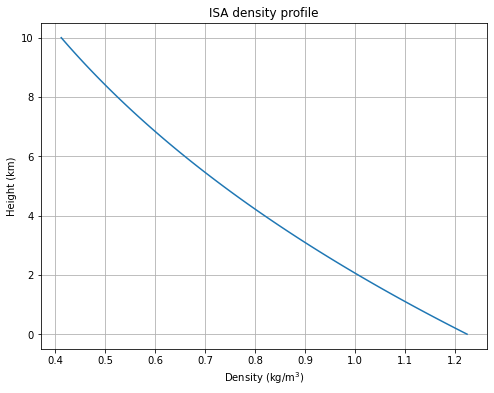

In [148]:
height = np.arange(0, 10.01, 0.1)*units.km
density = environment_density(height)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(density, height)
ax.grid()
ax.set(
    xlabel='Density (kg/m$^3$)',
    ylabel='Height (km)',
    title='ISA density profile')
plt.show()

## Temperature and specific humidity after precipitation

The increase $dq$ in the parcel's specific humidity is equal to the ratio of the mass of liquid water added to the total mass of the parcel (including the liquid water).

The latent heat required to evaporate the water is
$$ \frac{dQ}{m} = -L~dq$$
and the parcel remains at constant pressure as the heat is added so the change in temperature is
$$
    c_p~dT = -L~dq \\
    \Leftrightarrow \qquad T' = T_E - \frac{L~dq}{c_p}.
$$
We see that $dT$ is independent of the starting temperature.

In [21]:
def temperature_change(dq):
    """
    Calculates the temperature change due to evaporation of water.
    """
    
    dT = - const.water_heat_vaporization * dq / const.dry_air_spec_heat_press
    return dT.to(units.delta_degC)

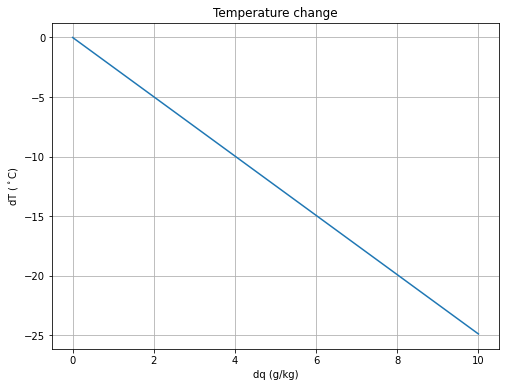

In [22]:
dq = np.arange(0, 10.1e-3, 1e-3)
dT = temperature_change(dq)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(dq*1e3, dT)
ax.grid()
ax.set(
    xlabel='dq (g/kg)',
    ylabel=r'dT ($^\circ$C)',
    title='Temperature change')
plt.show()

### Maximum specific humidity increase

We must be careful to limit the amount by which we increase a parcel's specific humidity when performing these calculations, since they assume that the parcel is subsaturated and no liquid water is present. The lowest temperature the parcel can be cooled to by evaporation of liquid water is the wet-bulb temperature, and the maximum temperature decrease is the difference between the dry- and wet-bulb temperatures:
$$
    \frac{L~dq_{max}}{c_p} = T - T_W
$$
This gives a maximum specific humidity increase of
$$
    dq_{max} = \frac{c_p(T - T_W)}{L}.
$$

In [25]:
def maximum_specific_humidity_change(height):
    """
    Calculates the specific humidity increase required to saturate the parcel.
    """
    
    pressure = mpcalc.height_to_pressure_std(height)
    temperature = environment_temperature(height)
    dewpoint = mpcalc.dewpoint_from_relative_humidity(temperature, 0.1)
    wetbulb_temperature = mpcalc.wet_bulb_temperature(
        pressure, temperature, dewpoint)
    dq_max = (const.dry_air_spec_heat_press 
              * (temperature - wetbulb_temperature)
              / const.water_heat_vaporization)
    return dq_max.to(units.dimensionless)

We can also find this value by recognising that the initial specific humidity plus the maximum specific humidity change will be equal to the saturation specific humidity at the new pressure and temperature:
$$
\begin{align}
    q_0(p,T) + dq_{max} &= q^{*}(p, T + dT(dq)) \\
    \Leftrightarrow \qquad q^{*}(p, T + dT(dq)) - q_0(p,T) - dq_{max} &= 0.
\end{align}
$$
We can use a root-finding algorithm to find the value of $dq_{max}$ that satisfies this equality.

In [101]:
def dq_root(dq, height):
    pressure = mpcalc.height_to_pressure_std(height)
    initial_temperature = environment_temperature(height)
    initial_specific_humidity = environment_specific_humidity(height)
    
    final_temperature = initial_temperature + temperature_change(dq)
    saturation_mixing_ratio = mpcalc.saturation_mixing_ratio(
        pressure, final_temperature)
    saturation_specific_humidity = mpcalc.specific_humidity_from_mixing_ratio(
        saturation_mixing_ratio)
    return saturation_specific_humidity - initial_specific_humidity - dq

def maximum_specific_humidity_change_alternate(height):
    height = np.atleast_1d(height)
    sol = [
        root_scalar(dq_root, args=(z,), bracket=[0, 5e-3]).root
        for z in height]
    return np.squeeze(concatenate(sol))

We plot both solutions and see that they are in good agreement. The root-finding method appears to be more efficient.

In [155]:
height = np.arange(0, 10.01, 0.1)*units.km

In [159]:
%%time
dq_max = maximum_specific_humidity_change(height)

CPU times: user 5.36 s, sys: 41.2 ms, total: 5.4 s
Wall time: 5.47 s


In [158]:
%%time
dq_max_alternate = maximum_specific_humidity_change_alternate(height)

CPU times: user 3.62 s, sys: 44.6 ms, total: 3.67 s
Wall time: 4 s


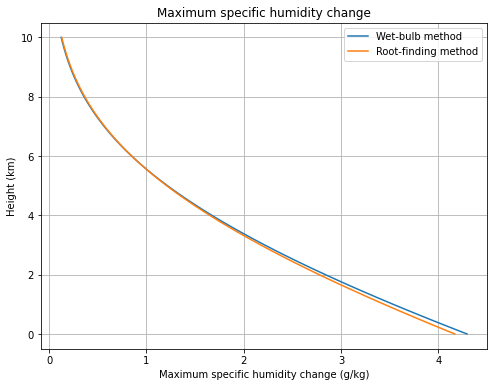

In [62]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(dq_max*1e3, height, label='Wet-bulb method')
ax.plot(dq_max_alternate*1e3, height, label='Root-finding method')
ax.grid()
ax.legend()
ax.set(
    xlabel='Maximum specific humidity change (g/kg)',
    ylabel='Height (km)',
    title='Maximum specific humidity change')
plt.show()

## Buoyancy after precipitation

The buoyant force on the parcel per unit mass is
$$
    b = \frac{\rho_E - \rho_P}{\rho_P} g
$$
where the subscripts $P$ and $E$ denote the parcel and environment respectively.

In [66]:
def parcel_density(height, initial_height, specific_humidity_change):
    """
    Calculates the density of a parcel after precipitation.
    
    Args:
        height: The height of the parcel.
        initial_height: The initial height of the parcel (i.e., its
            height when the precipitation occurred).
        specific_humidity_change: The change in specific humidity
            that resulted from the precipitation.
            
    Returns:
        The density of the parcel.
    """
    
    initial_pressure = mpcalc.height_to_pressure_std(initial_height)
    pressure = mpcalc.height_to_pressure_std(height)
    initial_temperature = (environment_temperature(initial_height)
                           + temperature_change(specific_humidity_change))
    
    initial_specific_humidity = environment_specific_humidity(initial_height)
    mixing_ratio = mpcalc.mixing_ratio_from_specific_humidity(
        initial_specific_humidity + specific_humidity_change)
    
    temperature = mpcalc.dry_lapse(
        pressure, initial_temperature, reference_pressure=initial_pressure)
    density = mpcalc.density(pressure, temperature, mixing_ratio)
    
    return density

def parcel_buoyancy(height, initial_height, specific_humidity_change):
    """
    Calculates the buoyancy of a parcel after precipitation.
    
    Args:
        height: The height of the parcel.
        initial_height: The initial height of the parcel (i.e., its
            height when the precipitation occurred).
        specific_humidity_change: The change in specific humidity
            that resulted from the precipitation.
            
    Returns:
        The buoyant force per unit mass on the parcel.
    """
    
    density = parcel_density(height, initial_height, specific_humidity_change)
    buoyancy = (environment_density(height) - density) / density * const.g
    return buoyancy

The density and buoyancy profiles for a typical parcel are shown below.

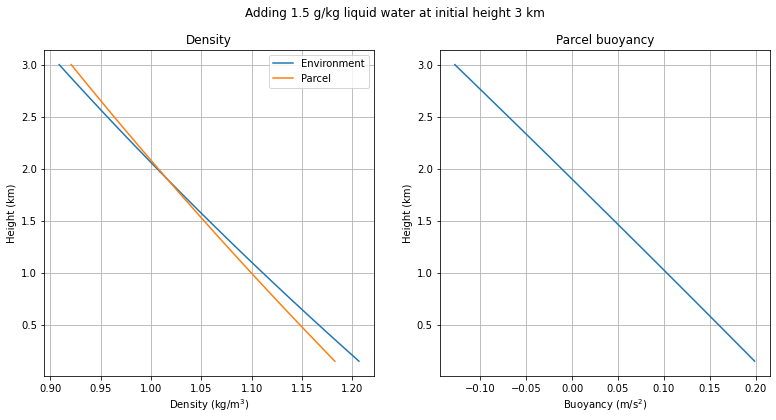

In [154]:
height = np.arange(3000, 100, -50)*units.meter
density = parcel_density(height, height[0], 1.5e-3)
buoyancy = parcel_buoyancy(height, height[0], 1.5e-3)

fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(121)
ax.plot(environment_density(height), height.to(units.km), label='Environment')
ax.plot(density, height.to(units.km), label='Parcel')
ax.legend()
ax.grid()
ax.set(
    xlabel=r'Density (kg/m$^3$)',
    ylabel='Height (km)',
    title='Density')

ax2 = fig.add_subplot(122)
ax2.plot(buoyancy, height.to(units.km))
ax2.grid()
ax2.set(
    xlabel=r'Buoyancy (m/s$^2$)',
    ylabel='Height (km)',
    title='Parcel buoyancy')

fig.suptitle('Adding 1.5 g/kg liquid water at initial height 3 km')
plt.show()

We see that the parcel is initially negatively buoyant, but becomes positively buoyant as it descends. We therefore expect to observe oscillations.

### Level of neutral buoyancy

We can use a root-finding algorithm to find the height at which the parcel is neutrally buoyant for a range of initial heights and specific humidity changes.

In [110]:
def parcel_buoyancy_root_function(
        height, initial_height, specific_humidity_change):
    """
    Calculates the buoyancy of a parcel after precipitation.
    
    Args:
        height: The height of the parcel in metres, as a dimensionless
            number.
        initial_height: The initial height of the parcel (i.e., its
            height when the precipitation occurred).
        specific_humidity_change: The change in specific humidity
            that resulted from the precipitation.
            
    Returns:
        The buoyant force per unit mass on the parcel.
    """
    
    buoyancy = parcel_buoyancy(
        height*units.meter, initial_height, specific_humidity_change).m
    return buoyancy

def neutral_buoyancy_level(initial_height, specific_humidity_change):
    """
    Calculates the neutral buoyancy height of a parcel.
    
    Args:
        initial_height: The initial height of the parcel.
        specific_humidity_change: The change in specific humidity due to
            evaporation.
            
    Returns:
        The height at which the buoyancy of the parcel is zero.
    """
    
    initial_height = np.atleast_1d(initial_height)
    specific_humidity_change = np.atleast_1d(specific_humidity_change)
    sol = np.zeros((len(initial_height), len(specific_humidity_change)))
    
    for i, z0 in enumerate(initial_height):
        for ii, dq in enumerate(specific_humidity_change):
            if dq <= maximum_specific_humidity_change_alternate(z0):
                try:
                    sol[i,ii] = root_scalar(
                        parcel_buoyancy_root_function,
                        args=(z0, dq),
                        bracket=[0, 10e3]).root
                except ValueError:
                    sol[i,ii] = 0
            else:
                sol[i,ii] = np.nan
    
    return sol/1e3*units.km

In [115]:
initial_height = np.arange(0, 10.01, 0.3)*units.km
specific_humidity_change = np.arange(0, 4.001e-3, 0.25e-3)
level = neutral_buoyancy_level(initial_height, specific_humidity_change)

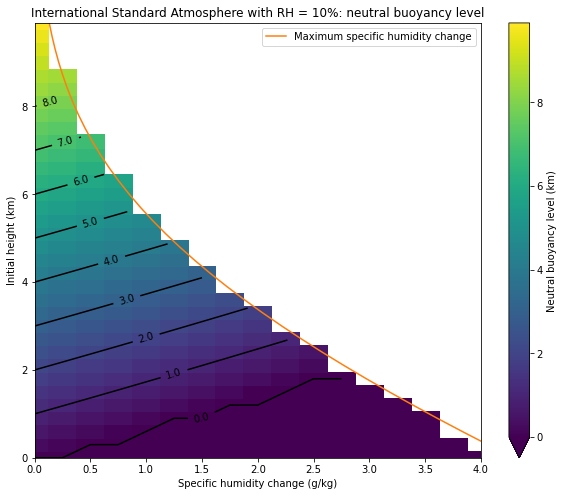

In [122]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

mesh = ax.pcolormesh(
    specific_humidity_change*1e3, initial_height, level,
    shading='nearest')
cbar = plt.colorbar(mesh, extend='min')
cbar.set_label('Neutral buoyancy level (km)')

contour = ax.contour(
    specific_humidity_change*1e3, initial_height, level, 
    levels=np.arange(0, 9.1, 1),
    colors='k',
)
ax2.clabel(contour, fmt='%1.1f')

ax.plot(
    maximum_specific_humidity_change(initial_height)*1e3, initial_height,
    label='Maximum specific humidity change', color='tab:orange')
ax.legend()

ax.set(
    xlabel='Specific humidity change (g/kg)',
    ylabel='Initial height (km)',
    title=('International Standard Atmosphere with RH = 10%: '
           'neutral buoyancy level'))
ax.set_xlim(0,4)
plt.show()

fig.savefig(
    fig_path + 'isa_neutral_buoyancy_level.png', dpi=300, facecolor='w',
    bbox_inches='tight')

We see that the neutral buoyancy level increases with initial height, but decerases for larger changes in specific humidity. This is because parcels that have more water evaporated into them are colder and thus less dense, needing to descend further to reach equilibrium.

## Parcel motion

Neglecting all forces other than buoyancy, the equation of motion for the parcel is the second-order ODE
$$\frac{d^2z}{dt^2} = b(z)$$
which can be written as the first-order system
$$
    \frac{d}{dt} \begin{pmatrix} z \\ w \end{pmatrix} = \begin{pmatrix} w \\ b \end{pmatrix}.
$$
We will solve this system numerically to find the motion of the parcel, $z(t)$.

In [123]:
def trajectory_ode(time, state, initial_height, specific_humidity_change):
    buoyancy = parcel_buoyancy(
        state[0]*units.meter, initial_height*units.meter,
        specific_humidity_change)
    return [state[1], buoyancy.magnitude]

### Motion vs. specific humidity change, initial height 3 km

We now solve the equation of motion for a range of specific humidity increases, fixing the initial height.

In [143]:
time = np.arange(0, 1300, 20)
initial_state = [3000, 0]  # starting at rest at 3km height
specific_humidity_change = np.arange(0, 2.0001e-3, 0.025e-3)

trajectory = np.zeros((len(specific_humidity_change), len(time)))
velocity = np.zeros((len(specific_humidity_change), len(time)))

for i in range(len(specific_humidity_change)):
    sol = solve_ivp(
        trajectory_ode, [np.min(time), np.max(time)], initial_state,
        t_eval=time, args=(initial_state[0], specific_humidity_change[i]))
    trajectory[i,:] = sol.y[0,:]
    velocity[i,:] = sol.y[1,:]
    sys.stdout.write(
        '\rCalculating profile {0} of {1}.'
        '   '.format(i+1, len(specific_humidity_change)))

Calculating profile 81 of 81.   

The displacement of a typical parcel over time is shown below.

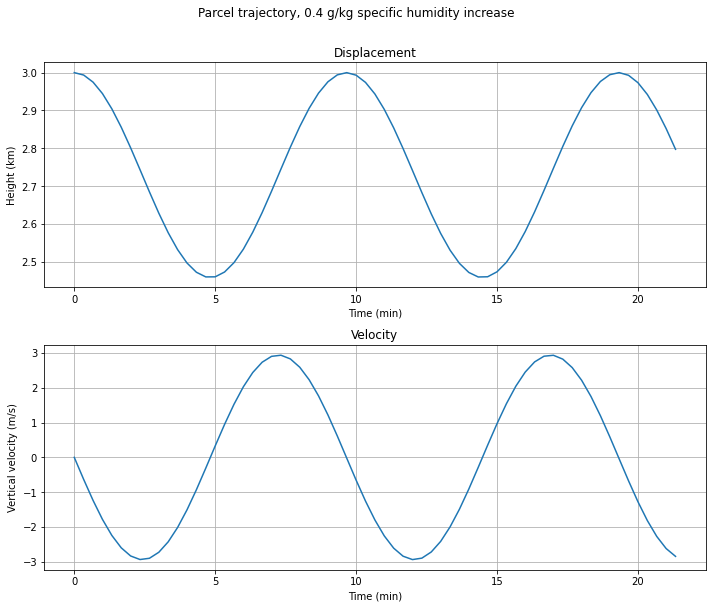

In [125]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(211)
ax.plot(time/60, trajectory[15,:]/1e3)
ax.grid()
ax.set(
    xlabel='Time (min)',
    ylabel='Height (km)',
    title='Displacement')

ax2 = fig.add_subplot(212)
ax2.plot(time/60, velocity[15,:])
ax2.grid()
ax2.set(
    xlabel='Time (min)',
    ylabel='Vertical velocity (m/s)',
    title='Velocity')

fig.tight_layout()
fig.suptitle(
    'Parcel trajectory, {0:.1f} g/kg specific humidity '
    'increase'.format(specific_humidity_change[15]*1e3),
    y=1.05)
plt.show()

The buoyancy of the parcel is an approximately linear function of height, so we see sinusoidal vertical oscillations.

We now show the motion of all the parcels on a colour plot.

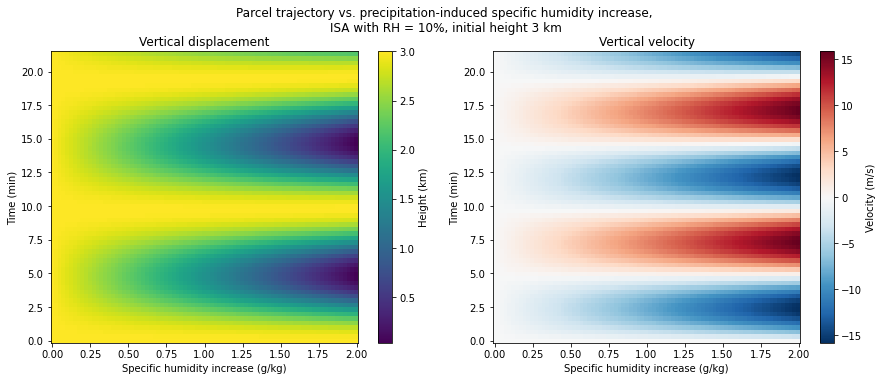

In [144]:
fig = plt.figure(figsize=(12.5,5))

ax1 = fig.add_subplot(121)
mesh = ax1.pcolormesh(
    specific_humidity_change*1e3, time/60, 
    trajectory.T/1e3, shading='nearest')
cbar = plt.colorbar(mesh)
cbar.set_label('Height (km)')
ax1.set(
    xlabel='Specific humidity increase (g/kg)',
    ylabel='Time (min)',
    title='Vertical displacement')

ax2 = fig.add_subplot(122)
mesh = ax2.pcolormesh(
    specific_humidity_change*1e3, time/60, 
    velocity.T, shading='nearest', cmap='RdBu_r')
cbar = plt.colorbar(mesh)
cbar.set_label('Velocity (m/s)')
ax2.set(
    xlabel='Specific humidity increase (g/kg)',
    ylabel='Time (min)',
    title='Vertical velocity')

fig.tight_layout()
fig.suptitle(
    'Parcel trajectory vs. precipitation-induced specific humidity increase, '
    '\nISA with RH = 10%, initial height 3 km',
    y=1.05)
plt.show()

fig.savefig(
    fig_path + 'isa_trajecory_vs_q_change_3km.png', dpi=300,
    facecolor='w', bbox_inches='tight')

As more water is evaporated into the parcel, the amplitude of the resulting oscillations increases, but there is no appreciable change in their period.

### Trajectory vs. specific humidity change, initial height 7.5 km

We repeat calculations of the previous section for a different inital height.

In [136]:
maximum_specific_humidity_change(7500*units.meter)

0.0004532450915894134 <Unit('dimensionless')>

In [137]:
time = np.arange(0, 1300, 20)
initial_state = [7500, 0]
specific_humidity_change = np.arange(0, 0.45001e-3, 0.01e-3)

trajectory2 = np.zeros((len(specific_humidity_change), len(time)))
velocity2 = np.zeros((len(specific_humidity_change), len(time)))

for i in range(len(specific_humidity_change)):
    sol = solve_ivp(
        trajectory_ode, [np.min(time), np.max(time)], initial_state,
        t_eval=time, args=(initial_state[0], specific_humidity_change[i]))
    trajectory2[i,:] = sol.y[0,:]
    velocity2[i,:] = sol.y[1,:]
    sys.stdout.write(
        '\rCalculating profile {0} of {1}.'
        '   '.format(i+1, len(specific_humidity_change)))

Calculating profile 46 of 46.   

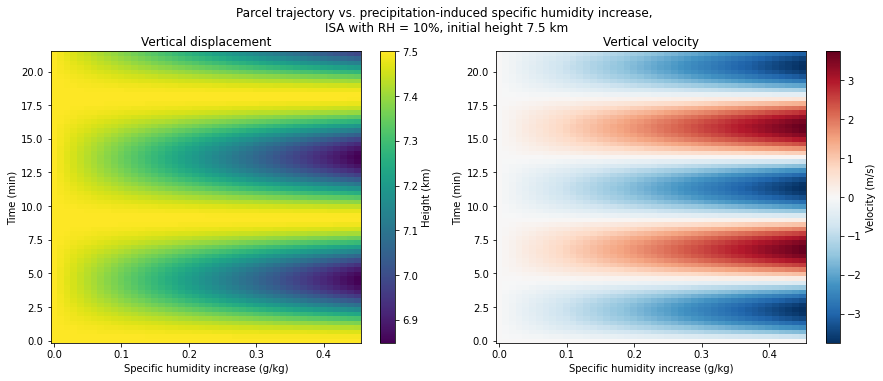

In [138]:
fig = plt.figure(figsize=(12.5,5))

ax1 = fig.add_subplot(121)
mesh = ax1.pcolormesh(
    specific_humidity_change*1e3, time/60, 
    trajectory2.T/1e3, shading='nearest')
cbar = plt.colorbar(mesh)
cbar.set_label('Height (km)')
ax1.set(
    xlabel='Specific humidity increase (g/kg)',
    ylabel='Time (min)',
    title='Vertical displacement')

ax2 = fig.add_subplot(122)
mesh = ax2.pcolormesh(
    specific_humidity_change*1e3, time/60, 
    velocity2.T, shading='nearest', cmap='RdBu_r')
cbar = plt.colorbar(mesh)
cbar.set_label('Velocity (m/s)')
ax2.set(
    xlabel='Specific humidity increase (g/kg)',
    ylabel='Time (min)',
    title='Vertical velocity')

fig.tight_layout()
fig.suptitle(
    'Parcel trajectory vs. precipitation-induced specific humidity increase, '
    '\nISA with RH = 10%, initial height 7.5 km',
    y=1.05)
fig.savefig(
    fig_path + 'isa_trajecory_vs_q_change_7km.png', dpi=300,
    facecolor='w', bbox_inches='tight')
plt.show()

The general behaviour is almost identical to that for an initial height of 3 km, but the period is slightly shorter.

### Trajectory vs. initial height, specific humidity change 0.5 g/kg

We now fix the specific humidity increase and vary the initial height.

In [139]:
maximum_specific_humidity_change(7*units.km)

0.0005652282295514611 <Unit('dimensionless')>

In [140]:
time = np.arange(0, 1300, 20)
initial_state = np.array([[z0, 0] for z0 in np.arange(2000, 7001, 100)])
specific_humidity_change = 0.5e-3

trajectory = np.zeros((initial_state.shape[0], len(time)))
velocity = np.zeros((initial_state.shape[0], len(time)))

for i in range(initial_state.shape[0]):
    sol = solve_ivp(
        trajectory_ode, [np.min(time), np.max(time)], initial_state[i,:],
        t_eval=time, args=(initial_state[i,0], specific_humidity_change))
    trajectory[i,:] = sol.y[0,:]
    velocity[i,:] = sol.y[1,:]
    sys.stdout.write(
        '\rCalculating profile {0} of {1}.'
        '   '.format(i+1, initial_state.shape[0]))

Calculating profile 51 of 51.   

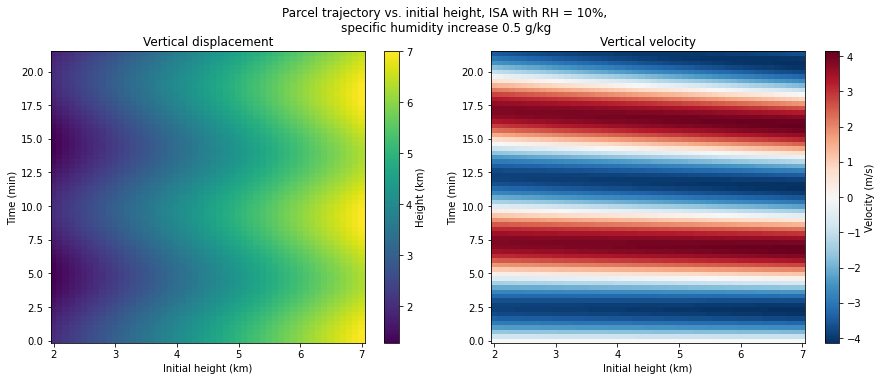

In [141]:
fig = plt.figure(figsize=(12.5,5))

ax1 = fig.add_subplot(121)
mesh = ax1.pcolormesh(
    initial_state[:,0]/1e3, time/60, 
    trajectory.T/1e3, shading='nearest')
cbar = plt.colorbar(mesh)
cbar.set_label('Height (km)')
ax1.set(
    xlabel='Initial height (km)',
    ylabel='Time (min)',
    title='Vertical displacement')

ax2 = fig.add_subplot(122)
mesh = ax2.pcolormesh(
    initial_state[:,0]/1e3, time/60, 
    velocity.T, shading='nearest', cmap='RdBu_r')
cbar = plt.colorbar(mesh)
cbar.set_label('Velocity (m/s)')
ax2.set(
    xlabel='Initial height (km)',
    ylabel='Time (min)',
    title='Vertical velocity')

fig.tight_layout()
fig.suptitle(
    'Parcel trajectory vs. initial height, ISA with RH = 10%, '
    '\nspecific humidity increase 0.5 g/kg',
    y=1.05)
fig.savefig(
    fig_path + 'isa_trajecory_vs_initial_height_2-7km.png', dpi=300,
    facecolor='w', bbox_inches='tight')
plt.show()

We see that there is a slight decrease in period for larger initial heights. This indicates that the upper atmosphere is more stable to convection than the lower atmosphere, i.e., that the buoyancy of the parcel varies more rapidly with height there.

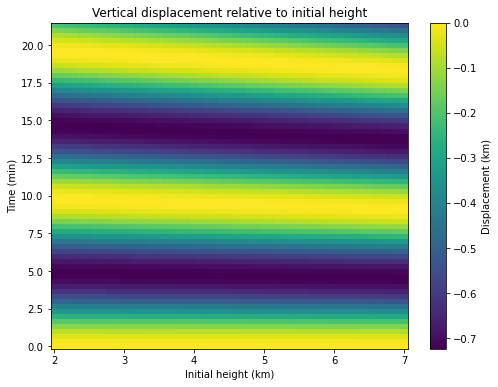

In [142]:
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_subplot(111)
mesh = ax1.pcolormesh(
    initial_state[:,0]/1e3, time/60, 
    trajectory.T/1e3 - initial_state[:,0]/1e3, shading='nearest')
cbar = plt.colorbar(mesh)
cbar.set_label('Displacement (km)')
ax1.set(
    xlabel='Initial height (km)',
    ylabel='Time (min)',
    title='Vertical displacement relative to initial height')
plt.show()

If we subtract the initial height from each profile, we can see that the amplitude of the oscillations is independent of initial height.